In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([0, 0])  # each age group has asymptomatic infectives
Is0 = np.array([0, 0])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

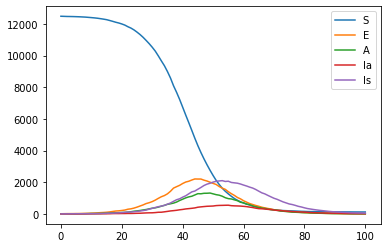

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

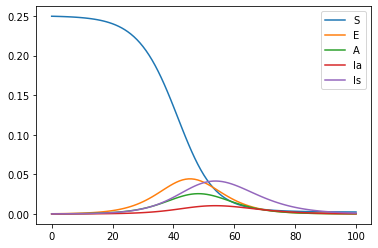

In [5]:
# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = x[:,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAI5R(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)

plt.plot(x_det[:, 0], label='S')
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.legend()
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-5404.451132455047
3.0075089931488037


In [7]:
alpha_g = 0.3
beta_g = 0.1
gIa_g = 0.2 
gIs_g = 0.2 
gE_g = 0.4
gA_g = 0.5 

guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, ftol=1e-6, verbose=True)

print('best estimates: ', params)
print('no. of iterations: ', nit)

For  [0.3 0.1 0.2 0.2 0.4 0.5] , (-log P):  87406.39525671011
For  [0.30001 0.1     0.2     0.2     0.4     0.5    ] , (-log P):  87406.4724923322
For  [0.3     0.10001 0.2     0.2     0.4     0.5    ] , (-log P):  87418.5242777486
For  [0.3     0.1     0.20001 0.2     0.4     0.5    ] , (-log P):  87406.50513995388
For  [0.3     0.1     0.2     0.20001 0.4     0.5    ] , (-log P):  87407.14927024771
For  [0.3     0.1     0.2     0.2     0.40001 0.5    ] , (-log P):  87406.9892227461
For  [0.3     0.1     0.2     0.2     0.4     0.50001] , (-log P):  87406.71228479313
For  [1.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05] , (-log P):  6797239987.605322
For  [2.e-05 1.e-05 1.e-05 1.e-05 1.e-05 1.e-05] , (-log P):  4811111364.554875
For  [1.e-05 2.e-05 1.e-05 1.e-05 1.e-05 1.e-05] , (-log P):  6773636113.367596
For  [1.e-05 1.e-05 2.e-05 1.e-05 1.e-05 1.e-05] , (-log P):  6789153046.816053
For  [1.e-05 1.e-05 1.e-05 2.e-05 1.e-05 1.e-05] , (-log P):  6037918912.517215
For  [1.e-05 1.e-05 1.e-0

For  [0.18238731 0.01985124 0.12611847 0.15011956 0.20734173 0.31860284] , (-log P):  -5317.629074026443
For  [0.18239731 0.01985124 0.12611847 0.15011956 0.20734173 0.31860284] , (-log P):  -5317.622701141906
For  [0.18238731 0.01986124 0.12611847 0.15011956 0.20734173 0.31860284] , (-log P):  -5317.8624820318855
For  [0.18238731 0.01985124 0.12612847 0.15011956 0.20734173 0.31860284] , (-log P):  -5317.62873808324
For  [0.18238731 0.01985124 0.12611847 0.15012956 0.20734173 0.31860284] , (-log P):  -5317.5536041090745
For  [0.18238731 0.01985124 0.12611847 0.15011956 0.20735173 0.31860284] , (-log P):  -5317.55377911449
For  [0.18238731 0.01985124 0.12611847 0.15011956 0.20734173 0.31861284] , (-log P):  -5317.686095208509
For  [0.18410578 0.0202166  0.12801403 0.14856395 0.20111153 0.32997934] , (-log P):  -5390.579931640184
For  [0.18411578 0.0202166  0.12801403 0.14856395 0.20111153 0.32997934] , (-log P):  -5390.576093370156
For  [0.18410578 0.0202266  0.12801403 0.14856395 0.201

For  [0.18537331 0.02003139 0.13039052 0.14473466 0.20050612 0.33302009] , (-log P):  -5404.403967795187
For  [0.18537331 0.02002139 0.13040052 0.14473466 0.20050612 0.33302009] , (-log P):  -5404.365050552885
For  [0.18537331 0.02002139 0.13039052 0.14474466 0.20050612 0.33302009] , (-log P):  -5404.360811900134
For  [0.18537331 0.02002139 0.13039052 0.14473466 0.20051612 0.33302009] , (-log P):  -5404.3638086529745
For  [0.18537331 0.02002139 0.13039052 0.14473466 0.20050612 0.33303009] , (-log P):  -5404.359819237879
For  [0.18636256 0.02001909 0.13197722 0.14456497 0.20060259 0.3326839 ] , (-log P):  -5404.782996416573
For  [0.18637256 0.02001909 0.13197722 0.14456497 0.20060259 0.3326839 ] , (-log P):  -5404.787830995463
For  [0.18636256 0.02002909 0.13197722 0.14456497 0.20060259 0.3326839 ] , (-log P):  -5404.82468590056
For  [0.18636256 0.02001909 0.13198722 0.14456497 0.20060259 0.3326839 ] , (-log P):  -5404.780269807247
For  [0.18636256 0.02001909 0.13197722 0.14457497 0.200

For  [0.19721609 0.02005683 0.1383267  0.14254421 0.20032626 0.33177915] , (-log P):  -5407.448362713996
For  [0.19721609 0.02005683 0.1383267  0.14253421 0.20033626 0.33177915] , (-log P):  -5407.44946885063
For  [0.19721609 0.02005683 0.1383267  0.14253421 0.20032626 0.33178915] , (-log P):  -5407.448453325146
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.464045543185
For  [0.19772636 0.02005475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.464039993366
For  [0.19771636 0.02006475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.463940943379
For  [0.19771636 0.02005475 0.13842069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.46405427256
For  [0.19771636 0.02005475 0.13841069 0.14248511 0.20041806 0.33177397] , (-log P):  -5407.464015870657
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20042806 0.33177397] , (-log P):  -5407.464004801566
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041

For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041806 0.33178397] , (-log P):  -5407.464066712757
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.464045543185
For  [0.19772636 0.02005475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.464039993366
For  [0.19771636 0.02006475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.463940943379
For  [0.19771636 0.02005475 0.13842069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.46405427256
For  [0.19771636 0.02005475 0.13841069 0.14248511 0.20041806 0.33177397] , (-log P):  -5407.464015870657
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20042806 0.33177397] , (-log P):  -5407.464004801566
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041806 0.33178397] , (-log P):  -5407.464066712757
For  [0.19771636 0.02005475 0.13841069 0.14247511 0.20041806 0.33177397] , (-log P):  -5407.464045558795
For  [0.19772636 0.02005475 0.13841069 0.14247511 0.2004

In [9]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = estimator.make_params_dict(params)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-5407.464046140226
2.8944618701934814
